# Set up

In [ ]:
# Install dependency
%pip install python-louvain

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import networkx as nx
import seaborn as sns

from collections import Counter
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data

from networkx.algorithms import approximation
from networkx.algorithms.community import greedy_modularity_communities
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix

# define path to dataset directory
dataset_path = '/notebooks/dataset/'


# Processing

In [20]:
def data_cleansing(dataset):
    # Replace negative values with 0
    dataset = np.where(dataset < 0, 0, dataset)
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
    num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            adj_matrix = graph_dataset[i, t, :, :]
            num_edges = np.sum(adj_matrix > 0)
            if num_edges == 0:
                is_valid = False
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

def convert_to_pyg_data(adj_matrices, inp_features):
    pyg_data_list = []
    
    num_graphs = adj_matrices.shape[0]
    num_timepoints = adj_matrices.shape[1]
    
    for i in range(num_graphs):
        for t in range(num_timepoints):
            adj_matrix = adj_matrices[i, t]
            features = inp_features[i, t]
            
            # Get edge indices
            edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
            
            # Get edge attributes
            edge_attr = torch.tensor(adj_matrix[adj_matrix.nonzero()], dtype=torch.float)
            
            # Node features
            x = torch.tensor(features, dtype=torch.float)
            
            # Label (timepoint)
            y = torch.tensor([t], dtype=torch.long)
            
            pyg_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

def get_dataset_info(pyg_data_list):
    num_features = pyg_data_list[0].x.shape[1]
    all_labels = torch.cat([data.y for data in pyg_data_list])
    num_classes = torch.unique(all_labels).numel()
    return num_features, num_classes

# General Dataset
mutag_dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG', use_node_attr=True)
proteins_dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS', use_node_attr=True)
dd_dataset = TUDataset(root='/tmp/DD', name='DD', use_node_attr=True)
enzymes_dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)


# Connectomic Dataset
## Simulated Dataset
simulated_adj = np.load(dataset_path + 'simulated_adj.npy')
simulated_adj = simulated_adj[:, :, :, :,0] #only take the domain 1
simulated_cleaned = data_cleansing(simulated_adj)
simulated_adj = check_and_drop_invalid_graphs(simulated_cleaned)
simulated_features = np.load(dataset_path + 'simulated_laplacian_features.npy')
simulated_features = simulated_features[:, :, :, :,0]
simulated_num_samples, simulated_num_classes, simulated_num_nodes, simulated_num_features = simulated_features.shape 
simulated_dataset =  convert_to_pyg_data(simulated_adj, simulated_features)

## OASIS Dataset
oasis = np.load(dataset_path + 'oasis_adj.npy')
oasis_cleaned = data_cleansing(oasis)
oasis_adj = check_and_drop_invalid_graphs(oasis_cleaned)
oasis_features = np.load(dataset_path + 'oasis_laplacian_features.npy')
oasis_num_samples, oasis_num_classes, oasis_num_nodes, oasis_num_features = oasis_features.shape 
oasis_dataset =  convert_to_pyg_data(oasis_adj, oasis_features)

## EMCI-AD Dataset
emci = np.load(dataset_path + 'emci-ad_adj.npy')
emci_cleaned = data_cleansing(emci)
emci_adj = check_and_drop_invalid_graphs(emci_cleaned)
emci_features = np.load(dataset_path + 'emci-ad_laplacian_features.npy')
emci_num_samples, emci_num_classes, emci_num_nodes, emci_num_features = emci_features.shape 
emci_dataset =  convert_to_pyg_data(emci_adj, emci_features) 

## SLIM160 Dataset
slim160 = np.load(dataset_path + 'slim160_adj.npy')
slim160_cleaned = data_cleansing(slim160)
slim160_adj = check_and_drop_invalid_graphs(slim160_cleaned)
slim160_features = np.load(dataset_path + 'slim160_laplacian_features_8.npy')
slim160_num_samples, slim160_num_classes, slim160_num_nodes, slim160_num_features = slim160_features.shape 
slim160_dataset =  convert_to_pyg_data(slim160_adj, slim160_features) 


# Graph Classification Dataset

In [37]:
# Function to perform EDA on the datasets
def perform_eda(dataset, dataset_name):
    # Class distribution
    labels = [data.y.item() for data in dataset]
    class_distribution = Counter(labels)
    num_classes = dataset.num_classes
    
    print(f"\n{dataset_name} Dataset EDA:")
    print(f"   Number of graphs: {len(dataset)}")
    print(f"   Class distribution: {class_distribution}")
    
    # Number of nodes per graph
    num_nodes = [data.num_nodes for data in dataset]
    average_num_nodes = np.mean(num_nodes)
    std_num_nodes = np.std(num_nodes)
    print(f"   Average number of nodes per graph:{average_num_nodes:.2f}±{std_num_nodes:.2f}")
    print(f"   Maximum number of nodes in a graph: {max(num_nodes)}")
    print(f"   Minimum number of nodes in a graph: {min(num_nodes)}")
    
    # Number of edges per graph
    num_edges = [data.num_edges for data in dataset]
    average_num_edges = np.mean(num_edges)
    std_num_edges = np.std(num_edges)
    print(f"   Average number of edges per graph:{average_num_edges:.2f}±{std_num_edges:.2f}")
    print(f"   Maximum number of edges in a graph: {max(num_edges)}")
    print(f"   Minimum number of edges in a graph: {min(num_edges)}")

    # Plotting class distribution
    plt.figure(figsize=(4, 4))
    plt.bar(class_distribution.keys(), class_distribution.values(), color='c')
    plt.xlabel('Labels', fontsize=14)
    plt.ylabel('#Graphs', fontsize=14)
    plt.title(f'{dataset_name}-Class Distribution', fontsize=16)
    plt.xticks(range(num_classes))
    plt.show()

    # Plotting number of nodes distribution
    plt.figure(figsize=(4, 4))
    plt.hist(num_nodes, bins=20, color='m', edgecolor='black')
    plt.xlabel('#Nodes', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'{dataset_name}-Nodes Distribution', fontsize=16)
    plt.show()
    
    # Plotting number of edges distribution
    plt.figure(figsize=(4, 4))
    plt.hist(num_edges, bins=20, color='y', edgecolor='black')
    plt.xlabel('#Edges', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'{dataset_name}-Edges Distribution', fontsize=16)
    plt.show()

def evaluate_topology(dataset):
    degree_distributions = []
    clustering_coeffs = []
    avg_path_lengths = []
    diameters = []
    densities = []
    modularities = []
    girths = []

    for data in dataset:
        # Convert PyTorch Geometric data to NetworkX graph
        G = to_networkx(data, to_undirected=True)

        # 1. Degree Distribution
        degrees = [d for n, d in G.degree()]
        degree_distribution = sum(degrees) / len(degrees)
        degree_distributions.append(degree_distribution)

        # 2. Clustering Coefficient
        clustering_coeff = nx.average_clustering(G)
        clustering_coeffs.append(clustering_coeff)

        # 3. Average Path Length and 4. Diameter (only for connected components)
        if nx.is_connected(G):
            avg_path_length = nx.average_shortest_path_length(G)
            avg_path_lengths.append(avg_path_length)

            diameter = nx.diameter(G)
            diameters.append(diameter)
        else:
            # Handle disconnected graphs
            # Calculate avg path length and diameter for each connected component, then average
            component_lengths = []
            component_diameters = []
            for component in nx.connected_components(G):
                subgraph = G.subgraph(component)
                component_lengths.append(nx.average_shortest_path_length(subgraph))
                component_diameters.append(nx.diameter(subgraph))
            avg_path_lengths.append(sum(component_lengths) / len(component_lengths))
            diameters.append(sum(component_diameters) / len(component_diameters))

        # 5. Graph Density
        density = nx.density(G)
        densities.append(density)

        # 6. Modularity (Requires community detection)
        try:
            import community as community_louvain
            partition = community_louvain.best_partition(G)
            modularity = community_louvain.modularity(partition, G)
            modularities.append(modularity)
        except ImportError:
            print("Community module not installed. Skipping modularity calculation.")
            modularities.append(float('nan'))

        # 7. Girth (length of the shortest cycle)
        try:
            girth = nx.algorithms.cycles.find_cycle(G)
            girths.append(len(girth))
        except nx.exception.NetworkXNoCycle:
            girths.append(float('inf'))  # No cycle means infinite girth

    # Calculate average and standard deviation of metrics across all graphs in the dataset
    avg_degree_distribution = np.mean(degree_distributions)
    std_degree_distribution = np.std(degree_distributions)

    avg_clustering_coeff = np.mean(clustering_coeffs)
    std_clustering_coeff = np.std(clustering_coeffs)

    avg_avg_path_length = np.mean(avg_path_lengths)
    std_avg_path_length = np.std(avg_path_lengths)

    avg_diameter = np.mean(diameters)
    std_diameter = np.std(diameters)

    avg_density = np.mean(densities)
    std_density = np.std(densities)

    avg_modularity = np.mean(modularities)
    std_modularity = np.std(modularities)

    avg_girth = np.mean(girths)
    std_girth = np.std(girths)

    # Print the results with the desired format
    print(f"Average Degree Distribution: {avg_degree_distribution:.4f} ± {std_degree_distribution:.2f}")
    print(f"Average Clustering Coefficient: {avg_clustering_coeff:.4f} ± {std_clustering_coeff:.2f}")
    print(f"Average Path Length: {avg_avg_path_length:.4f} ± {std_avg_path_length:.2f}")
    print(f"Average Diameter: {avg_diameter:.4f} ± {std_diameter:.2f}")
    print(f"Average Density: {avg_density:.4f} ± {std_density:.2f}")
    print(f"Average Modularity: {avg_modularity:.4f} ± {std_modularity:.2f}")
    print(f"Average Girth: {avg_girth:.4f} ± {std_girth:.2f}")

    return

### General EDA


MUTAG Dataset EDA:
   Number of graphs: 188
   Class distribution: Counter({1: 125, 0: 63})
   Average number of nodes per graph:17.93±4.58
   Maximum number of nodes in a graph: 28
   Minimum number of nodes in a graph: 10
   Average number of edges per graph:39.59±11.37
   Maximum number of edges in a graph: 66
   Minimum number of edges in a graph: 20


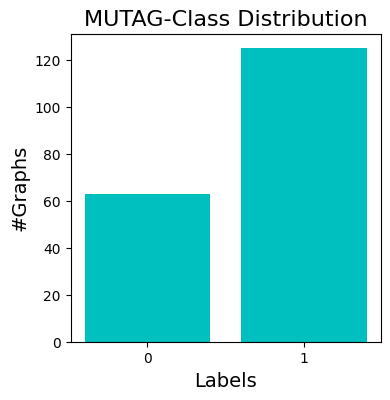

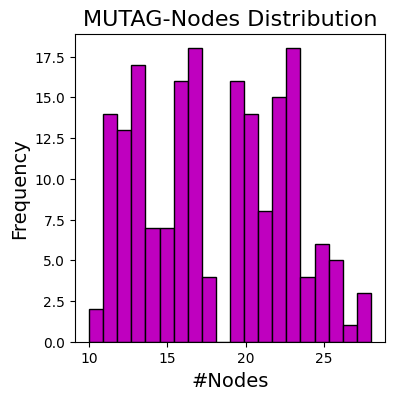

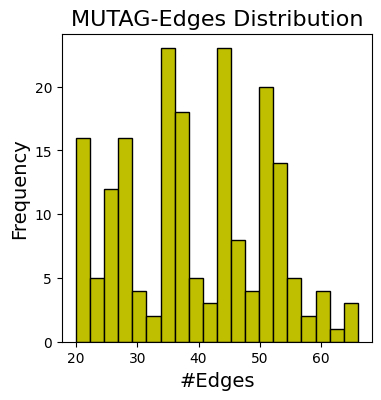

In [38]:
perform_eda(mutag_dataset, "MUTAG")


PROTEINS Dataset EDA:
   Number of graphs: 1113
   Class distribution: Counter({0: 663, 1: 450})
   Average number of nodes per graph:39.06±45.76
   Maximum number of nodes in a graph: 620
   Minimum number of nodes in a graph: 4
   Average number of edges per graph:145.63±169.20
   Maximum number of edges in a graph: 2098
   Minimum number of edges in a graph: 10


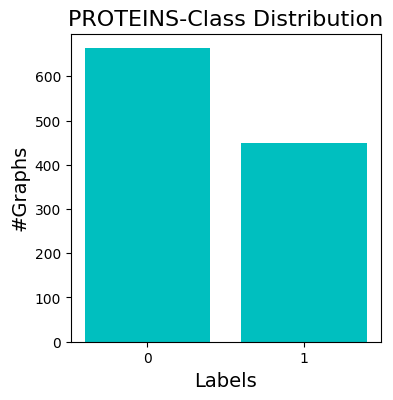

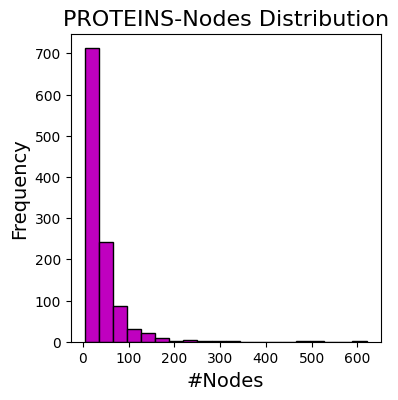

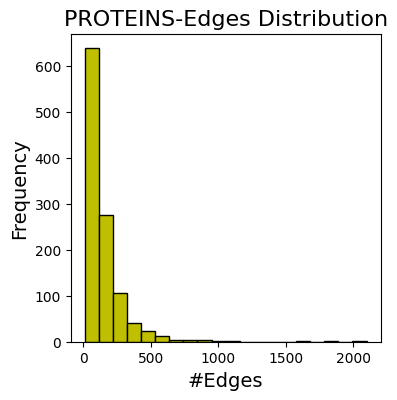

In [39]:
perform_eda(proteins_dataset, "PROTEINS")


DD Dataset EDA:
   Number of graphs: 1178
   Class distribution: Counter({0: 691, 1: 487})
   Average number of nodes per graph:284.32±272.00
   Maximum number of nodes in a graph: 5748
   Minimum number of nodes in a graph: 30
   Average number of edges per graph:1431.32±1387.81
   Maximum number of edges in a graph: 28534
   Minimum number of edges in a graph: 126


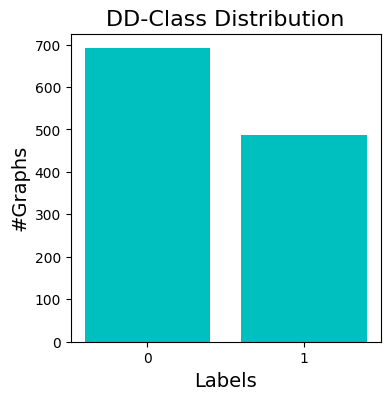

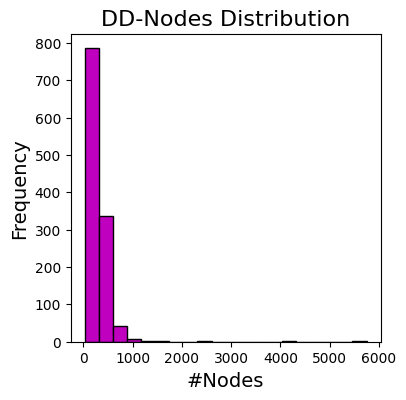

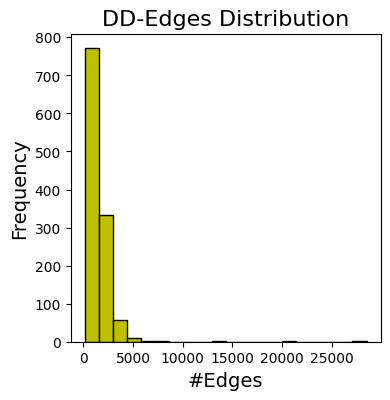

In [40]:
perform_eda(dd_dataset, "DD")


ENZYMES Dataset EDA:
   Number of graphs: 600
   Class distribution: Counter({5: 100, 4: 100, 0: 100, 1: 100, 2: 100, 3: 100})
   Average number of nodes per graph: 32.63
   Maximum number of nodes in a graph: 126
   Minimum number of nodes in a graph: 2
   Average number of edges per graph: 124.27
   Maximum number of edges in a graph: 298
   Minimum number of edges in a graph: 2


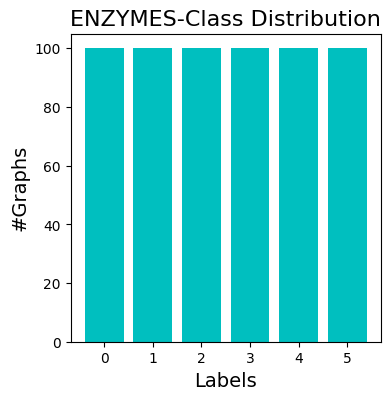

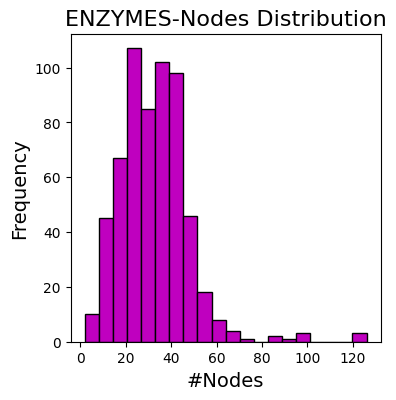

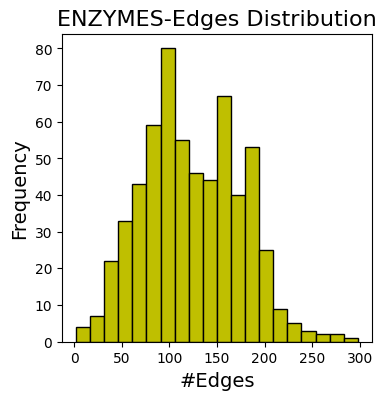

In [35]:
perform_eda(enzymes_dataset, "ENZYMES")

### Topology Analysis

In [12]:
# Load the datasets
print("MUTAG Dataset")
mutag_dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG', use_node_attr=True)
mutag_results = evaluate_topology(mutag_dataset)

print("\nPROTEIN Dataset")
proteins_dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS', use_node_attr=True)
proteins_results = evaluate_topology(proteins_dataset)

print("\nD&D Dataset")
dd_dataset = TUDataset(root='/tmp/DD', name='DD', use_node_attr=True)
dd_results = evaluate_topology(dd_dataset)

print("\nEnzymes Dataset")
enzymes_dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
enzymes_results = evaluate_topology(enzymes_dataset)


MUTAG Dataset
Average Degree Distribution: 2.1888 ± 0.11
Average Clustering Coefficient: 0.0000 ± 0.00
Average Path Length: 3.6262 ± 0.60
Average Diameter: 8.2181 ± 1.84
Average Density: 0.1385 ± 0.04
Average Modularity: 0.4621 ± 0.06
Average Girth: 6.0479 ± 0.92

PROTEIN Dataset
Average Degree Distribution: 3.7346 ± 0.42
Average Clustering Coefficient: 0.5142 ± 0.23
Average Path Length: 4.6590 ± 2.72
Average Diameter: 11.4700 ± 7.85
Average Density: 0.2122 ± 0.20
Average Modularity: 0.5516 ± 0.19
Average Girth: inf ± nan

D&D Dataset
Average Degree Distribution: 4.9791 ± 0.59
Average Clustering Coefficient: 0.4794 ± 0.05
Average Path Length: 7.9486 ± 2.55
Average Diameter: 19.7626 ± 7.52
Average Density: 0.0278 ± 0.02
Average Modularity: 0.7825 ± 0.07
Average Girth: 3.1358 ± 0.62

Enzymes Dataset
Average Degree Distribution: 3.8626 ± 0.49
Average Clustering Coefficient: 0.4534 ± 0.20
Average Path Length: 4.3677 ± 1.61
Average Diameter: 10.7021 ± 4.67
Average Density: 0.1599 ± 0.11
Ave

# Graph Generation Dataset

## Topology Analysis

In [ ]:
print("Simulated Dataset")
simulated_results = evaluate_topology(simulated_dataset)

print("\nOASIS Dataset")
oasis_results = evaluate_topology(oasis_dataset)

print("\nEMCI-AD Dataset")
emci_results = evaluate_topology(emci_dataset)

print("\nSLIM160 Dataset")
slim160_results = evaluate_topology(slim160_dataset)

## Temporal Analysis

In [41]:
# Function to calculate the distribution of connectivity values for each time point
def calculate_timepoint_distribution(connectivity_matrices):
    n_subjects, n_timepoints, n_node, _ = connectivity_matrices.shape
    # Reshape the data to [n_timepoints, n_subjects * n_node * n_node] to get the distribution
    distributions = connectivity_matrices.reshape(n_subjects, n_timepoints, -1)
    
    return distributions

# Function to plot the KDE distributions of the connectivity matrices for each time point in a dataset
def plot_dataset_distribution(dataset, dataset_name):
    distributions = calculate_timepoint_distribution(dataset)
    n_subjects, n_timepoints, _ = distributions.shape
    
    plt.figure(figsize=(6, 4))
    
    for t in range(n_timepoints):
        # Plot the KDE distribution for the current time point
        sns.kdeplot(distributions[:, t, :].flatten(), label=f'Time Point {t+1}')
    
    plt.xlabel('Connectivity Values', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'Connectivity Distribution ({dataset_name})', fontsize=16)
    # plt.title(f'Distribution of Connectivity Values Over Time for {dataset_name}')
    plt.legend()
    plt.show()

#### Line Plot

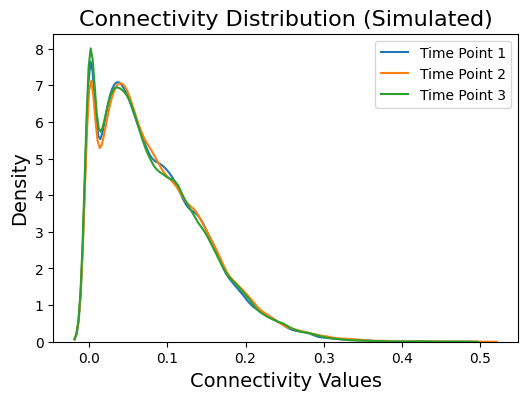

In [42]:
plot_dataset_distribution(simulated_adj, "Simulated")

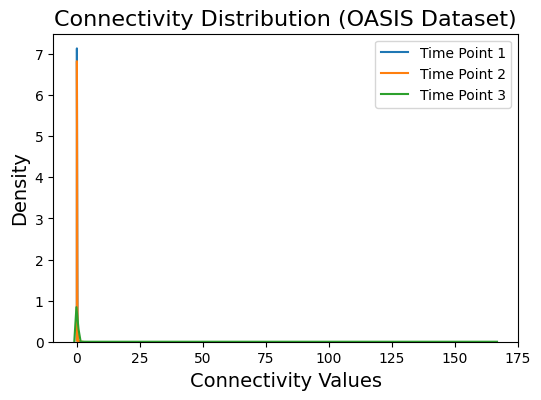

In [43]:
plot_dataset_distribution(oasis_adj, "OASIS Dataset")

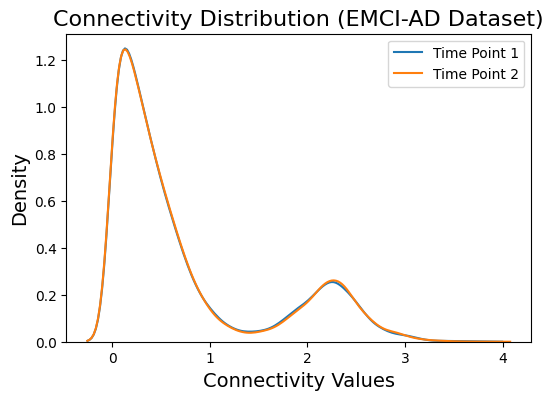

In [44]:
plot_dataset_distribution(emci_adj, "EMCI-AD Dataset")

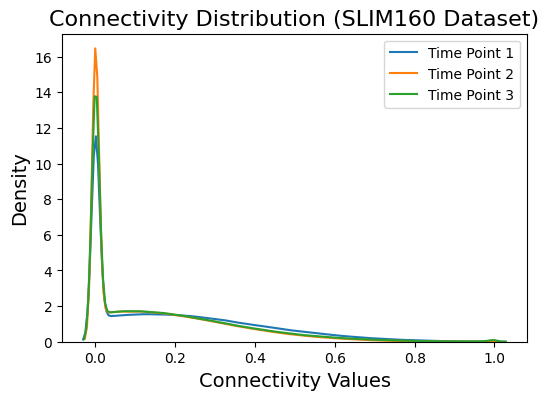

In [45]:
plot_dataset_distribution(slim160_adj, "SLIM160 Dataset")

### Violin Plot

In [26]:
import pandas as pd 
def prepare_data_for_violin_plot(connectivity_matrices):
    n_subjects, n_timepoints, n_node, _ = connectivity_matrices.shape
    # Reshape the data to [n_subjects * n_timepoints * n_node * n_node]
    data = connectivity_matrices.reshape(n_subjects, n_timepoints, -1)
    
    # Convert to a pandas DataFrame for easier plotting
    plot_data = []
    for t in range(n_timepoints):
        for subject in range(n_subjects):
            plot_data.extend([(f'Time Point {t+1}', value) for value in data[subject, t, :]])
    
    df = pd.DataFrame(plot_data, columns=['Time Point', 'Connectivity Value'])
    return df

# Function to plot the violin plot of connectivity values for each time point in a dataset
def plot_violin_plot(dataset, dataset_name):
    # Prepare the data
    df = prepare_data_for_violin_plot(dataset)
    
    # Create the violin plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Time Point', y='Connectivity Value', data=df, inner='quartile')
    
    plt.title(f'Violin Plot of Connectivity Values Over Time for {dataset_name} Dataset')
    plt.xlabel('Time Point')
    plt.ylabel('Connectivity Value')
    plt.show()

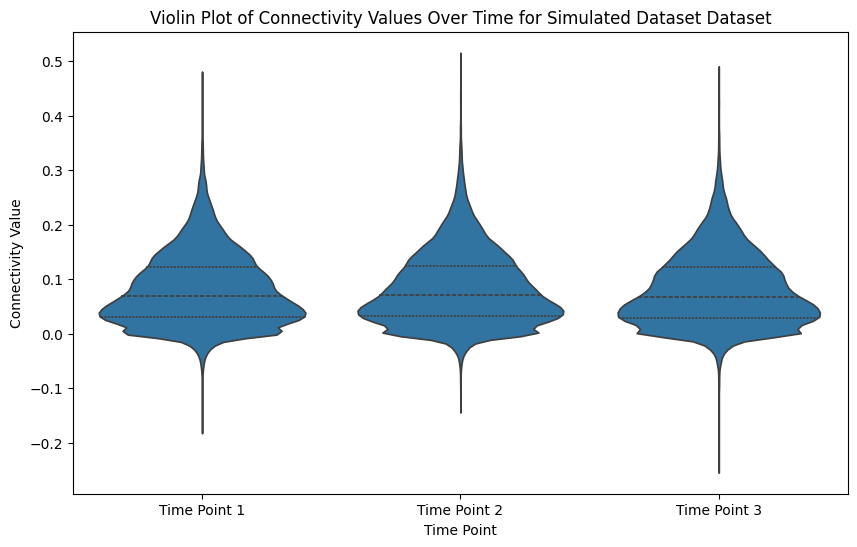

In [27]:
plot_violin_plot(simulated_adj, "Simulated")

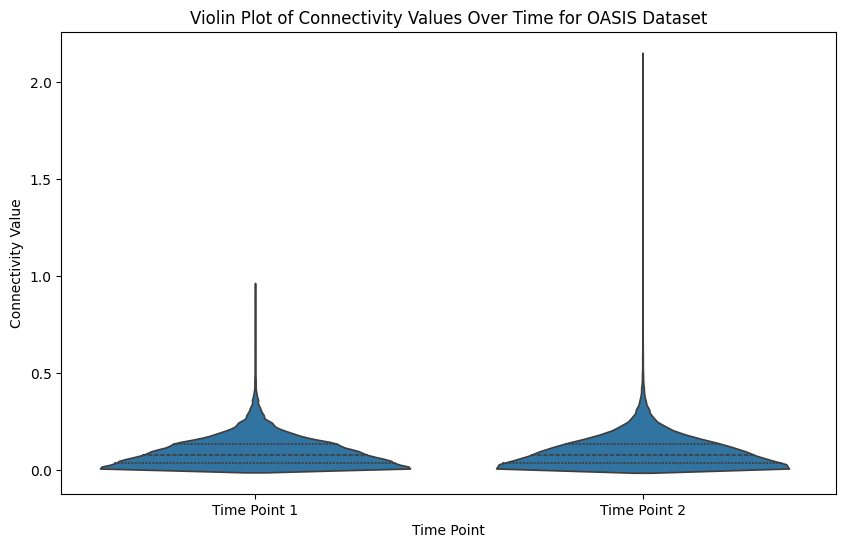

In [32]:
plot_violin_plot(oasis_adj[:,:2,:,:], "OASIS")

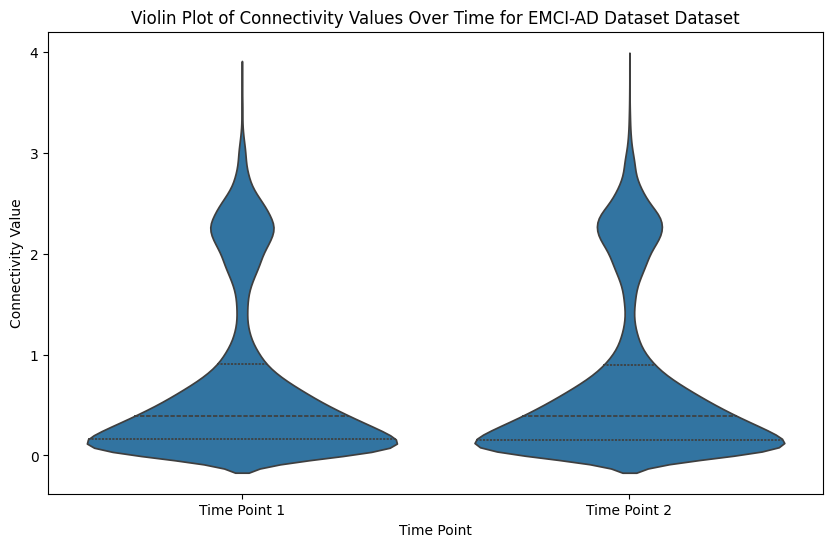

In [29]:
plot_violin_plot(emci_adj, "EMCI-AD")

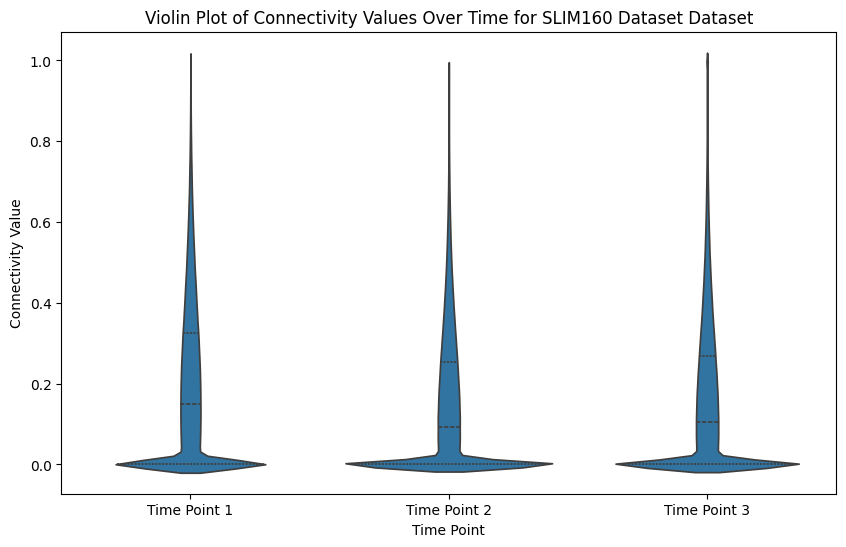

In [31]:
plot_violin_plot(slim160_adj, "SLIM160")

### Trajectory Shading Plot

In [34]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


def compute_trajectory_features(adj_matrices):
    """
    Compute features representing the trajectory of the graph over time for each subject.
    This example uses the mean of the adjacency matrices at each time point as a simple feature.
    
    :param adj_matrices: numpy array of shape [n_subjects, n_timepoints, n_nodes, n_nodes]
    :return: numpy array of shape [n_subjects, n_timepoints], representing the mean connectivity over time
    """
    n_subjects, n_timepoints, n_nodes, _ = adj_matrices.shape
    features = np.zeros((n_subjects, n_timepoints))

    for subject in range(n_subjects):
        for t in range(n_timepoints):
            features[subject, t] = np.mean(adj_matrices[subject, t])

    return features

def cluster_trajectories(trajectory_features, n_clusters=3):
    """
    Apply K-means clustering to the trajectory features.
    
    :param trajectory_features: numpy array of shape [n_subjects, n_timepoints]
    :param n_clusters: Number of clusters
    :return: Cluster labels for each subject
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(trajectory_features)
    
    return cluster_labels

def plot_clustered_trajectories(trajectory_features, cluster_labels, n_clusters=3):
    """
    Plot the trajectories of each cluster with the mean and shaded standard deviation.
    
    :param trajectory_features: numpy array of shape [n_subjects, n_timepoints]
    :param cluster_labels: Array of cluster labels for each subject
    :param n_clusters: Number of clusters
    """
    timepoints = np.arange(trajectory_features.shape[1])
    
    plt.figure(figsize=(10, 6))
    
    for cluster in range(n_clusters):
        cluster_data = trajectory_features[cluster_labels == cluster]
        mean_trajectory = np.mean(cluster_data, axis=0)
        std_trajectory = np.std(cluster_data, axis=0)
        
        plt.plot(timepoints, mean_trajectory, label=f'Cluster {cluster + 1}')
        plt.fill_between(timepoints, mean_trajectory - std_trajectory, mean_trajectory + std_trajectory, alpha=0.3)
    
    plt.xlabel('Timepoint')
    plt.ylabel('Feature Value (Mean Connectivity)')
    plt.title('Clustered Trajectories with Shaded STD')
    plt.legend(title='Cluster')
    plt.show()
    

/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


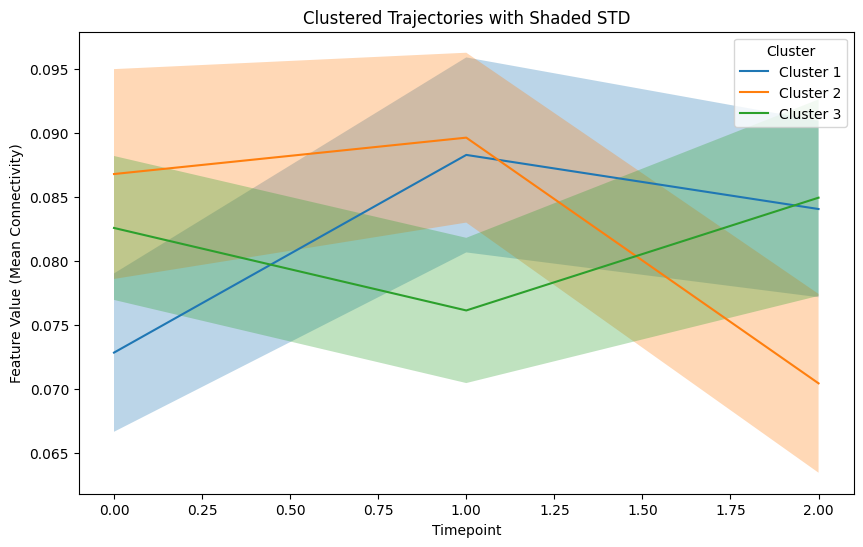

In [35]:
# Example usage:
trajectory_features = compute_trajectory_features(simulated_adj)
cluster_labels = cluster_trajectories(trajectory_features, n_clusters=3)
plot_clustered_trajectories(trajectory_features, cluster_labels, n_clusters=3)

/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


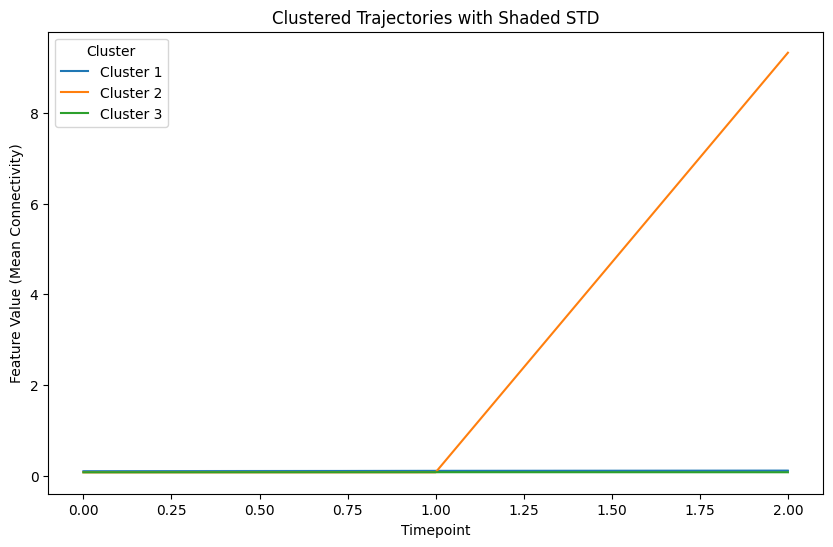

In [37]:
# Example usage:
trajectory_features = compute_trajectory_features(oasis_adj)
cluster_labels = cluster_trajectories(trajectory_features, n_clusters=3)
plot_clustered_trajectories(trajectory_features, cluster_labels, n_clusters=3)

/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


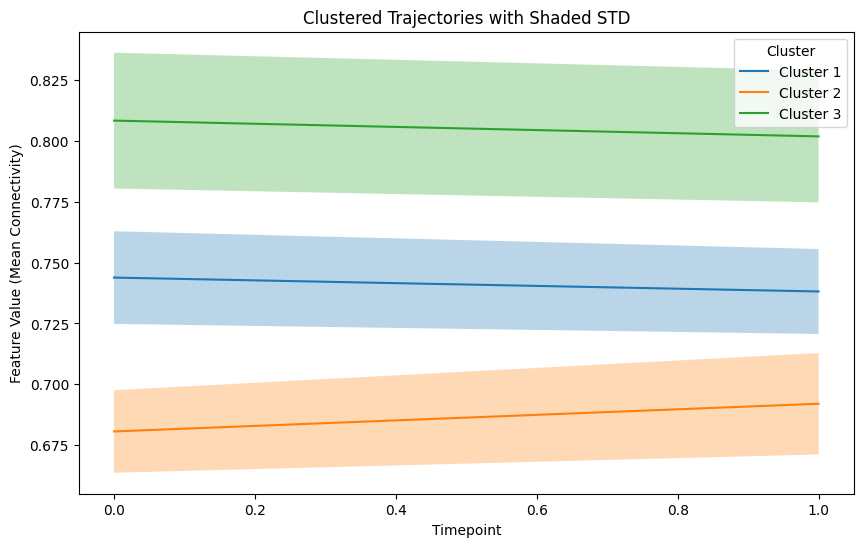

In [38]:
# Example usage:
trajectory_features = compute_trajectory_features(emci_adj)
cluster_labels = cluster_trajectories(trajectory_features, n_clusters=3)
plot_clustered_trajectories(trajectory_features, cluster_labels, n_clusters=3)

/Users/gitaayusalsabila/anaconda3/envs/doc_task_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


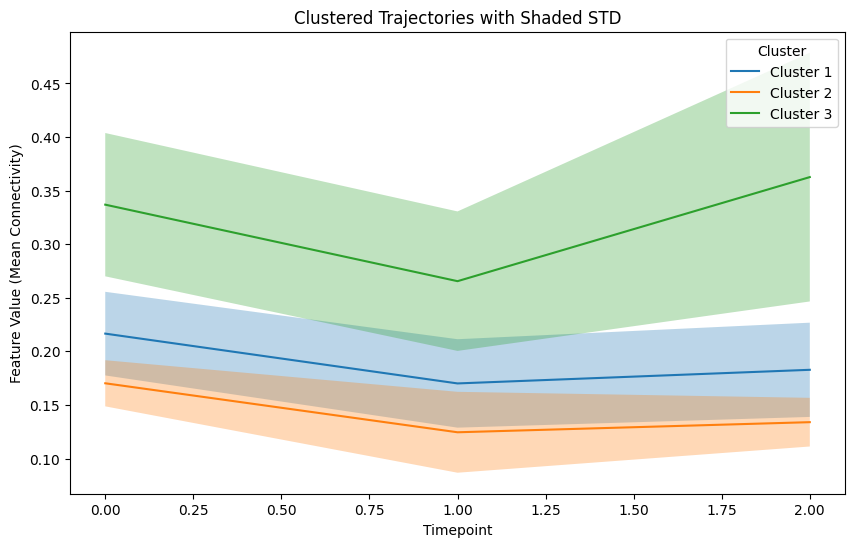

In [36]:
# Example usage:
trajectory_features = compute_trajectory_features(slim160_adj)
cluster_labels = cluster_trajectories(trajectory_features, n_clusters=3)
plot_clustered_trajectories(trajectory_features, cluster_labels, n_clusters=3)